# Introduction

This is a notebook to see if there is an impact of the socio-demographic variables on the tendency for the subject to get `Right` or `Wrong`. 
It also serves as a recoding and cleaning notebook to obtain a clean dataset that can be reused for other analysis in the future. 


## Import modules and functions

### Modules

In [1]:
# Import modules
import json
import csv
import math

import itertools 
from itertools import combinations

In [2]:
# Classic analysis imports
import numpy as np 
import pandas as pd 
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns

In [3]:
# Stat analysis import 
from sklearn import preprocessing
from sklearn.cluster import KMeans


import scipy 
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from statsmodels.sandbox.stats.multicomp import multipletests

import scikit_posthocs as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.stattools as stools

import statsmodels.stats as stats 

from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.anova import anova_lm

from statsmodels.stats import multicomp as mc
from statsmodels.miscmodels.ordinal_model import OrderedModel

import pingouin as pg

In [4]:
# options for the notebook
pd.set_option('display.max_colwidth',1000)
plt.style.use('seaborn')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [5, 5]

# Data

## Loading

In [5]:
# Setting up the folders 
data_folder = "../data/"
analysis_results_folder = "../results/"
plots_folders = "../plots"

# Filenames
dataset_filename = 'sondea_analisis_20210323_SONDEA.csv'
dataset_clean_filename = 'cleaned_dataset_per_subject.csv'

dataset_topic_filename = 'news _information _methodology_news.csv'
dataset_news_filename = 'details_news.csv'
dataset_news_full_filename = 'cleaned_dataset_per_news.csv'

In [6]:
# Load the raw dataset
df_raw = pd.read_csv('{}{}'.format(data_folder, dataset_filename),  sep=';')

In [7]:
# Load topic
df_topic = pd.read_csv('{}{}'.format(data_folder, dataset_topic_filename), sep=';')
df_topic = df_topic[['Titulo', 'General Topics ']]
df_topic.columns = ['news_title', 'topic']

In [8]:
# convert to datetime columns to type datetime
df_raw['dt_arrive'] = pd.to_datetime(df_raw['date_arrive'])
df_raw['dt_finish'] = pd.to_datetime(df_raw['date_finish'])

# create a new variable to store time completion (in minutes)
df_raw['time_completion_min'] = df_raw.apply(lambda row: round((row['dt_finish'] - row['dt_arrive']).seconds/60,3), axis=1)

#df_raw['dm_lugar'] = df_raw.apply(lambda row: row['dm_provincia'] if row['dm_provincia'] != 'Fuera de España' else unicodedata.normalize('NFD', row['dm_prov_otro'].strip().title()).encode('ascii', 'ignore').decode(), axis=1)
df_raw['dm_lugar_country'] = df_raw.apply(lambda row: row['dm_prov_otro'] if row['dm_provincia'] == 'Fuera de España' else 'España', axis=1)
#TODO [CCAA]

df_raw['dm_employment'] = df_raw.apply(lambda row: row['dm_empleo'] if row['dm_empleo'] != 'Otro' else row['dm_empleo_otro'].strip().title(), axis=1)


## Recoding

### Recode True - Fake news 

We recoded the different option of Fake news and True news and the answers to follow a easier format. Rather than having the answer being dependent to the question to know if it was a correct or no we did as following:

1. Recode the type of news as either `True` new or `Fake` news. 

1. In case of the subject thought a `True` news as `True`, the answer was recoded as `Right`

1. In case of the subject thought a `Fake` news was `Fake`, the answer was recoded as `Right`

1. In case of the subject thought a `True` news was `Fake`, the answer was recoded as `Wrong`

1. In case of the subject thought a `Fake` news was `True`, the answer was recoded as `Wrong`

In [9]:
# Recode the True - False and Fake news
df_raw = df_raw.rename(columns={'tysno_verdadera': 'True news', 'fysno_verdadera': "Fake news"})

# Recode the Si and No into Right and Wrong to avoid confusion
df_raw['True news'] = df_raw['True news'].replace({'sí': 'Right'})
df_raw['True news'] = df_raw['True news'].replace({'no': 'Wrong'})

df_raw['Fake news'] = df_raw['Fake news'].replace({'sí': 'Wrong'})
df_raw['Fake news'] = df_raw['Fake news'].replace({'no': 'Right'})

### Create count_error 

We created a variable called `count_error`. 
We simply check the number of time a subject did a mistake. 
* When the subject got `Right` to all answer, we coded `No error`
* If a subject did a mistake (regardless of considering a Fake news as True, or a True news as Fake), we recoded as `1 error`
* If a subject did 2 mistakes, we recoded as `2 errors`

In [10]:
# Get the number of error per profile
df_raw['count_error_int'] = (df_raw[['True news', 'Fake news']]=="Wrong").sum(axis="columns")
df_raw['count_error'] = df_raw['count_error_int']
df_raw['count_error'].value_counts()

df_raw = df_raw.astype({'count_error': 'category'})
# Transform the count errors into category type
df_raw.count_error.replace({0: 'No error', 1:'1 error', 2:'2 errors'}, inplace=True)



df_raw.count_error = pd.Categorical(df_raw.count_error, categories=['No error', '1 error', '2 errors'],ordered=True)

### Create the 4 categories variables

We created another way to group subjects. 
Here we followed the idea to divide in the 4 possible scenario

1. The subject got the `True` news `Right` and the `Fake` news `Right`: `TR-FR`

1. The subject got the `True` news `Right` and the `Fake` news `Wrong`: `TR-FW`

1. The subject got the `True` news `Wrong` and the `Fake` news `Right`: `TW-FR`

1. The subject got the `True` news `Wrong` and the `Fake` news `Wrong`: `TW-FW`

In [11]:
conditions = [
    (df_raw['True news'] == 'Right') & (df_raw['Fake news'] == 'Right'),
    (df_raw['True news'] == 'Right') & (df_raw['Fake news'] == 'Wrong'),
    (df_raw['True news'] == 'Wrong') & (df_raw['Fake news'] == 'Right'),
    (df_raw['True news'] == 'Wrong') & (df_raw['Fake news'] == 'Wrong'),
    ]

# create a list of the values we want to assign for each condition
values = ['TR-FR', 'TR-FW', 'TW-FR', 'TW-FW']
df_raw['cat_tf_rw'] = np.select(conditions, values)

In [12]:
df_raw['cat_tf_rw'].value_counts().to_frame()

,cat_tf_rw
TR-FR,447
TR-FW,267
TW-FR,232
TW-FW,117


### Create the 2 categories

Here, created a category with only the `Right` and `Wrong` distinction

In [13]:
df_raw['r_w'] = np.where(
    (df_raw['count_error_int'] > 0), 'W', 'R')

In [14]:
df_raw['r_w'].value_counts().to_frame()

,r_w
W,616
R,447


### Recode religion

We decided to recode the religion into a dichotomic variable. The logic behind is that there were a lot of of `Católico` (n=512), `Ateo` (n=237) and `Agnóstico` (n=164), while other religions where low in number (n<10) (see the table under). 
We could do it different and keep the following coding as alternative (not done here) but it is a sensitive decision.

* `Católico`

* `Ateo`

* `Agnóstico`

* `Other faiths` 

In [15]:
# Recode religion into believers, atheist, agnostic

## Get the value of Otro in dm_pref_religion
df_raw['dm_pref_religion'] = df_raw.apply(lambda row: row['dm_religion'] if row['dm_religion'] != 'Otro' else row['dm_rel_otro'].strip().title(), axis=1)


## Recode the different entries into believers-atheist/agnostics
religion = ['Católico', 'Islámico', 'Evangélico', 'Protestante', 'Budista', 'Cristiano', 'Protestante', 
             'Musulmán', 'Grigoriano Apostolico', 'Soy Cristiana', 'Católica No Practicante', 'Testigo De Jehová', 
             'Católico Pero No Acudo A Misa', 'Soy Cristiano, Creo En Dios', 'Católico No Practicante',
             'Es Largo De Explicar , Es Una Iglesia Moderna', 'Creo En Las Ciencias Ocultas Y La Espiritualidad',
             'Creo En Dios A Través De Jesucristo',
             'Sincretismo Pragmático', 'Creo En Dios A Través De Jesucristo.', 'Ortodoxo']

no_religion = ['Agnóstico', 'Soy Agnóstico', 'Ateo', 'Ningún Punto Religioso..Creo En La Vida.', 'Ni Creo Ni Dejo De Creer' ]

df_raw['recode_religion'] = df_raw['dm_pref_religion'].replace(religion, 'Religious')
df_raw['recode_religion'] = df_raw['recode_religion'].replace(no_religion, 'No religious')
# Code as None if not within these two categories
df_raw['recode_religion'] = np.where(df_raw['recode_religion'].isin(['Religious','No religious']), df_raw['recode_religion'], None)

In [16]:
df_raw['dm_pref_religion'].value_counts().to_frame()

,dm_pref_religion
Católico,512
Ateo,237
Agnóstico,164
NS/NC,91
Islámico,10
-,9
Evangélico,8
Cristiano,4
Budista,4
Protestante,4


After recoding, we obtained the following repartition between `Believers` and `Atheists/Agnostics`

In [17]:
df_raw['recode_religion'].value_counts().to_frame()

,recode_religion
Believers,555
Atheists/Agnostics,404


### Recode politics

This variable has been recoded into `Izquierda`, `Centro`, `Derecha`, from the original question. 
The recoding is not necessarily needed. Again we can decide to change that later. 

* `Izquierda`: 'Izquierda', 'Centro izquierda'

* `Centro`: 'Centro'

* `Derecha`: 'Derecha', 'Centro derecha'

In [18]:
df_raw['dm_politica'].value_counts().to_frame()

,dm_politica
Izquierda,262
NS/NC,220
Centro izquierda,180
Centro,180
Centro derecha,124
Derecha,84
-,13


In [19]:
# aggregate politics preferences into bigger groups (izquierda, derecha, centro)
def aggregate_politics(val):
    if val in ['Izquierda', 'Centro izquierda']:
        return 'Izquierda'
    elif val in ['Derecha', 'Centro derecha']:
        return 'Derecha'
    elif val == 'Centro':
        return val
    else:
        return None
df_raw['recode_politics'] = df_raw['dm_politica'].apply(aggregate_politics)

After recoding, we obtained the following repartition

In [20]:
df_raw['recode_politics'].value_counts().to_frame()

,recode_politics
Izquierda,442
Derecha,208
Centro,180


### Recode age

Age as been recoded to group in 3 categories:

* `<=18-34`: '< 18 años', '18-24 años', '25-34 años'

* `35-54`: '35-44 años', '45-54 años'

* `>55`: '55-65 años', '> 65 años'

In [21]:
# aggregate ages into bigger groups (18-34, 35-54, >54)
def aggregate_age(val):
    if val in ['< 18 años', '18-24 años', '25-34 años']:
        return '<=18-34'
    elif val in ['35-44 años', '45-54 años']:
        return '35-54'
    elif val in ['55-65 años', '> 65 años']:
        return '>55'
    elif val is None:
        return None
df_raw['recode_age'] = df_raw.dm_edad.apply(aggregate_age)

df_raw.recode_age = pd.Categorical(df_raw.recode_age, categories=['<=18-34', '35-54', '>55'],ordered=True)


df_raw.recode_age.value_counts().to_frame()

,recode_age
35-54,549
<=18-34,258
>55,256


### Recode education

Education has been recoded in two forms. One  is to group the subject into `Uni` vs `No Uni`. While the distinction makes sense regarding the data, it has been considered too *university-self-centerred*. Therefore we fall back on a three categories distinctions

* `up_to_secondaria`: 'Primaria', 'Secundaria', 'No tiene estudios en educación formal'

* `up_to_bac_3`: 'Formación Profesional', 'Bachillerato', 'Cou'

* `up_to_uni`: 'Master','Posgrado', 'Doctorado',  'Grado/Licenciatura'

In [22]:
# Recode education
df_raw['dm_education'] = df_raw.apply(lambda row: row['dm_educacion'] if row['dm_educacion'] != 'Otro' else row['dm_edu_otro'].strip().title(), axis=1)


#education_recoded_values = ['Primaria', 'Secundaria', 'Formación Profesional', 'Grado/Licenciatura', 'Master', 'Posgrado', 'Doctorado' ]

# Code as None if not within the list of education level
#df_raw['recode_education'] = np.where(df_raw['dm_education'].isin(education_recoded_values), df_raw['dm_education'], None)


# Recode education into broader categories
uni = ['Posgrado', 'Doctorado', 'Master', 'Grado/Licenciatura' ]
non_uni = ['No tiene estudios en educación formal', 'Formación Profesional', 'Primaria', 'Secundaria', 'Cou', 'Bachillerato']




df_raw['recode_education'] = df_raw['dm_education'].replace(uni, 'University studies')
df_raw['recode_education'] = df_raw['recode_education'].replace(non_uni, 'No university studies')



# Alternative recoding
up_to_secondaria = ['Primaria', 'Secundaria', 'No tiene estudios en educación formal']
up_to_bac_3 = ['Formación Profesional', 'Bachillerato', 'Cou']
up_to_university_level = ['Master','Posgrado', 'Doctorado',  'Grado/Licenciatura']


# Code as None if not within these categories
df_raw['recode_education'] = np.where(df_raw['recode_education'].isin(['University studies', 'No university studies']), df_raw['recode_education'], None)
df_raw.recode_education.value_counts()

df_raw['recode_education2'] = df_raw['dm_education'].replace(up_to_secondaria, 'up_to_secondaria')
df_raw['recode_education2'] = df_raw['recode_education2'].replace(up_to_bac_3, 'up_to_bac_3')
df_raw['recode_education2'] = df_raw['recode_education2'].replace(up_to_university_level, 'up_to_university_level')
df_raw.recode_education2.value_counts().to_frame()

,recode_education2
up_to_university_level,559
up_to_bac_3,307
up_to_secondaria,195
NS/NC,2


### Recode actions


In [23]:
# faf and taf are questions asked if the subject answer 'True' to the news in case of True and Fake news. 
# The faf will then for people who were wrong and the taf for people who were rignt
var_actions_f = ['faf_compartira_familia_amigos', 'faf_publicara_redes', 'faf_consultara_fuentes', 'faf_aplicara_aprendido', 'faf_no_accion']
var_actions_t = ['taf_compartira_familia_amigos', 'taf_publicara_redes', 'taf_consultara_fuentes', 'taf_aplicara_aprendido', 'taf_no_accion']
var_actions = var_actions_f + var_actions_t
df_raw.loc[:, var_actions] = df_raw.loc[:, var_actions].replace({'checked': True, 'unchecked': False})
df_raw.loc[:, var_actions]

,faf_compartira_familia_amigos,faf_publicara_redes,faf_consultara_fuentes,faf_aplicara_aprendido,faf_no_accion,taf_compartira_familia_amigos,taf_publicara_redes,taf_consultara_fuentes,taf_aplicara_aprendido,taf_no_accion
0,False,False,False,False,True,False,False,False,False,True
1,True,False,False,False,False,False,False,False,False,True
2,True,False,False,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False,False,True,False
4,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...
1058,False,False,False,False,True,True,False,False,False,False
1059,False,False,False,False,True,True,False,False,False,False
1060,False,False,True,False,False,False,False,True,False,False
1061,False,True,False,False,False,False,False,False,False,True


There is an issue with some subjects answering the no_action while answering other types of action at the same time


In [24]:
# There is an issue with some subjects answering the no_action while answering other types of action at the same time
df_raw['total_checked_f'] = df_raw.loc[:, var_actions_f].isin([True]).sum(axis=1)
df_raw['total_checked_t'] = df_raw.loc[:, var_actions_t].isin([True]).sum(axis=1)

In [25]:
# Drop the subjects when conflicting answer in case of analysing actions. 
df_raw[(df_raw['total_checked_f'] > 1) & (df_raw['faf_no_accion'] == True)][['total_checked_f', *var_actions_f]]

,total_checked_f,faf_compartira_familia_amigos,faf_publicara_redes,faf_consultara_fuentes,faf_aplicara_aprendido,faf_no_accion
92,2,False,False,False,True,True
94,2,False,False,True,False,True
97,2,False,False,True,False,True
259,2,False,False,True,False,True
344,2,False,False,True,False,True
534,2,False,False,True,False,True
588,2,False,False,True,False,True
670,2,False,False,True,False,True
673,2,False,False,True,False,True
742,2,False,False,False,True,True


In [26]:
# Drop the subjects when conflicting answer in case of analysing actions. 

for x in var_actions_f:
    df_raw.loc[(df_raw['total_checked_f'] > 1) & (df_raw['faf_no_accion'] == True), x] = np.NaN

In [27]:
df_raw[(df_raw['total_checked_t'] > 1) & (df_raw['taf_no_accion'] == True)][['total_checked_t', *var_actions_t]]

,total_checked_t,taf_compartira_familia_amigos,taf_publicara_redes,taf_consultara_fuentes,taf_aplicara_aprendido,taf_no_accion
79,2,False,False,True,False,True
94,2,False,False,True,False,True
238,2,False,False,False,True,True
327,3,False,False,True,True,True
332,2,False,False,False,True,True
367,2,False,False,False,True,True
394,2,True,False,False,False,True
450,3,False,False,True,True,True
508,2,False,False,True,False,True
516,2,False,False,False,True,True


In [28]:
# Drop the subjects when conflicting answer in case of analysing actions. 
for x in var_actions_t:
    df_raw.loc[(df_raw['total_checked_t'] > 1) & (df_raw['taf_no_accion'] == True), x] = np.NaN

In [29]:
### Recode justifications
# Rename two columns for tys that are different than the column from fys and create issue later in analysis
df_raw = df_raw.rename(columns={'tys_medio_comunicacion_conocido': 'tys_medio_conocido', 'tys_medio_comunicacion_fiable': 'tys_medio_fiable'})


In [30]:
var_justification_wrong = ['tno_aclaracion_desmintiendo',
'tno_medio_desconocido',
'tno_medio_poco_fiable',
'tno_fuentes_desconocidas',
'tno_fuentes_no_confiables',
'tno_sin_fuentes',
'tno_abordaje_no_serio',
'tno_no_coherente',
'tno_titulo_sensacionalista',
'tno_imagen_sensacionalista',
'tno_no_concuerda_creencias',
'tno_no_alineado_ideologia',
'tno_otro','fno_aclaracion_desmintiendo',
'fno_medio_desconocido',
'fno_medio_poco_fiable',
'fno_fuentes_desconocidas',
'fno_fuentes_no_confiables',
'fno_sin_fuentes',
'fno_abordaje_no_serio',
'fno_no_coherente',
'fno_titulo_sensacionalista',
'fno_imagen_sensacionalista',
'fno_no_concuerda_creencias',
'fno_no_alineado_ideologia',
'fno_otro']
var_justification_right = ['fys_recuerda_leida',
'fys_medio_conocido',
'fys_medio_fiable',
'fys_fuentes_conocidas',
'fys_fuentes_confiables',
'fys_abordaje_serio',
'fys_coherente',
'fys_concuerda_creencias',
'fys_alineado_ideologia',
'fys_otro',
'tys_recuerda_leida',
'tys_medio_conocido',
'tys_medio_fiable',
'tys_fuentes_conocidas',
'tys_fuentes_confiables',
'tys_abordaje_serio',
'tys_coherente',
'tys_concuerda_creencias',
'tys_alineado_ideologia',
'tys_otro']

var_justifications = var_justification_right + var_justification_wrong
df_raw.loc[:, var_justifications] = df_raw.loc[:, var_justifications].replace({'checked': True, 'unchecked': False, 'undisplayed': np.NaN})

### Recode NS/NC into Np.NaN
It seems the NS/NC is equal to `no answer`. We recoded globally accordingly. The consequence in all further analysis is that people who did not answer the question will be removed from the analysis. They are removed for the analysis they did not provide an answer, not removed from the dataset (therefore we will have different N).

In [31]:
# Replace the NS/NC as np.nan to exclude subject in analysis
df_raw = df_raw.replace('NS/NC', np.nan)

## Filtering

### On survey completion

To decide which data are considered as completed, the time to reach `time_news2` is use and it is 

In [32]:
# #FIXME The date_finish is never None. Therefore that datapoint is not relevant. 
fin = ~df_raw['date_finish'].isnull() # finished experiments
ini = df_raw['time_index']>0          # initiated or read news 1
read_only_1 = ini & (df_raw['time_news1']==0) # read only 1 news
read_both = df_raw['time_news1']>0    # read both news
got_to_ans = df_raw['time_news2']>0    # read both news and got to ans

In [33]:
# Filtering
df_all = df_raw
df_init = df_raw[ini]
df = df_raw[got_to_ans]

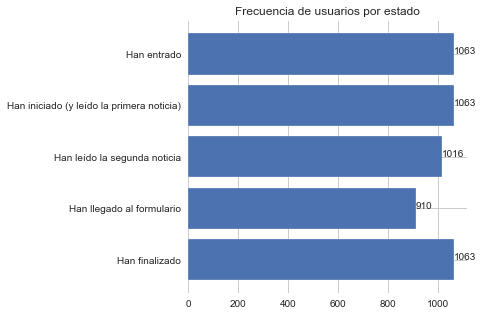

In [34]:
y = ['Han entrado','Han iniciado (y leído la primera noticia)','Han leído la segunda noticia', 'Han llegado al formulario', 'Han finalizado']
x = [df_all.shape[0], df_all[ini].shape[0], df_all[read_both].shape[0], df_all[got_to_ans].shape[0], df_all[fin].shape[0]]
plt.barh(y, x)
for index, value in enumerate(y):
    plt.text(x[index], index, str(x[index]))

plt.gca().invert_yaxis()
plt.title('Frecuencia de usuarios por estado')
plt.show()

The column `Han finalizado` is inconsistent with the other counts. After inspection it is because there is no `None` value for that variable.

In [35]:
df = df_raw[got_to_ans]

print('Size of the filtered sample: {}'.format(df.shape[0]))

Size of the filtered sample: 910


### On time completion

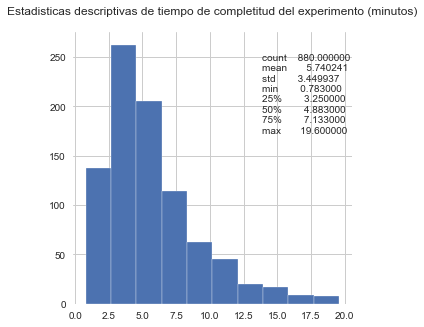

In [36]:
# df[df['time_completion_min']<=20]['time_completion_min'].plot.hist()
fig, ax = plt.subplots()
ax.hist(df[df['time_completion_min']<=20]['time_completion_min'])
plt.figtext(0.65,0.6, df[df['time_completion_min']<=20]['time_completion_min'].describe().to_string())
plt.title("Estadisticas descriptivas de tiempo de completitud del experimento (minutos)\n")
plt.show()

After looking at the data for the time completion, we decided to remove any subject that took less than 2 minutes to answer the survey. 

In [37]:
# Removing the subjects that answer in less or equal to 1 minutes to be sure we get subject that get focused. 
df[df['time_completion_min'] < 2]['time_completion_min'].count()

51

## Final dataset

In [38]:
df = df[df['time_completion_min'] > 2]
print('Size of the final filtered sample: {}'.format(df.shape[0]))

Size of the final filtered sample: 859


# Dataset from news perspective

## Melt the sampled dataset

In [39]:
# Transform the main df into df by news 
df_news = df.melt(id_vars=[*[i for i in df.columns if i not in ['fake_news', 'true_news']]])

df_news = df_news.rename(columns={'variable': 'type_news', 'value': 'news_title'})

## Add the justifications

In [40]:
# In case the subject thinks it is a Fake News (regardless of the news)
var_justification_true_wrong = ['tno_aclaracion_desmintiendo',
'tno_medio_desconocido',
'tno_medio_poco_fiable',
'tno_fuentes_desconocidas',
'tno_fuentes_no_confiables',
'tno_sin_fuentes',
'tno_abordaje_no_serio',
'tno_no_coherente',
'tno_titulo_sensacionalista',
'tno_imagen_sensacionalista',
'tno_no_concuerda_creencias',
'tno_no_alineado_ideologia',
'tno_otro']

var_justification_fake_right = ['fno_aclaracion_desmintiendo',
'fno_medio_desconocido',
'fno_medio_poco_fiable',
'fno_fuentes_desconocidas',
'fno_fuentes_no_confiables',
'fno_sin_fuentes',
'fno_abordaje_no_serio',
'fno_no_coherente',
'fno_titulo_sensacionalista',
'fno_imagen_sensacionalista',
'fno_no_concuerda_creencias',
'fno_no_alineado_ideologia',
'fno_otro']

## Creating it for the fake news
df_fake = df_news[df_news['type_news'] == 'fake_news'][[ 'news_title', *var_justification_fake_right]]
df_fake = df_fake.replace({True: 1, False: 0})
df_fake = df_fake.groupby('news_title').agg('mean')
df_fake.columns = ['justification_avg_' + '_'.join(i.split('_')[1:]) for i in df_fake.columns]

## Creating for the true news
df_true = df_news[df_news['type_news'] == 'true_news'][['news_title', *var_justification_true_wrong]]
df_true = df_true.replace({True: 1, False: 0})
df_true = df_true.groupby('news_title').agg('mean')
df_true.columns = ['justification_avg_' + '_'.join(i.split('_')[1:]) for i in df_true.columns]

## Append the two dataframe
df_avg_justification_fake = df_fake
df_avg_justification_fake = df_avg_justification_fake.append(df_true)
df_avg_justification_fake = df_avg_justification_fake.reset_index().rename(columns={'index': 'news_title'})

In [41]:
# In cases the subject is right for true news and wrong for fake news
var_justification_fake_wrong = ['fys_recuerda_leida',
'fys_medio_conocido',
'fys_medio_fiable',
'fys_fuentes_conocidas',
'fys_fuentes_confiables',
'fys_abordaje_serio',
'fys_coherente',
'fys_concuerda_creencias',
'fys_alineado_ideologia',
'fys_otro']

var_justification_true_right = ['tys_recuerda_leida',
'tys_medio_conocido',
'tys_medio_fiable',
'tys_fuentes_conocidas',
'tys_fuentes_confiables',
'tys_abordaje_serio',
'tys_coherente',
'tys_concuerda_creencias',
'tys_alineado_ideologia',
'tys_otro']

## Creating it for the fake news
df_fake = df_news[df_news['type_news'] == 'fake_news'][[ 'news_title', *var_justification_fake_wrong]]
df_fake = df_fake.replace({True: 1, False: 0})
df_fake = df_fake.groupby('news_title').agg('mean')
df_fake.columns = ['justification_avg_' + '_'.join(i.split('_')[1:]) for i in df_fake.columns]

## Creating for the true news
df_true = df_news[df_news['type_news'] == 'true_news'][['news_title', *var_justification_true_right]]
df_true = df_true.replace({True: 1, False: 0})
df_true = df_true.groupby('news_title').agg('mean')
df_true.columns = ['justification_avg_' + '_'.join(i.split('_')[1:]) for i in df_true.columns]

## Append the two dataframes
df_avg_justification_true = df_fake
df_avg_justification_true = df_avg_justification_true.append(df_true)
df_avg_justification_true = df_avg_justification_true.reset_index().rename(columns={'index': 'news_title'})

# Merging all the possibilities
df_avg_justification = df_avg_justification_fake.merge(df_avg_justification_true, on='news_title')

## Add the different actions

In [42]:
var_actions_f = ['faf_compartira_familia_amigos', 'faf_publicara_redes', 'faf_consultara_fuentes', 'faf_aplicara_aprendido', 'faf_no_accion']
var_actions_t = ['taf_compartira_familia_amigos', 'taf_publicara_redes', 'taf_consultara_fuentes', 'taf_aplicara_aprendido', 'taf_no_accion']


## Creating it for the fake news
df_fake = df_news[df_news['type_news'] == 'fake_news'][[ 'news_title', *var_actions_f]]
df_fake = df_fake.replace({True: 1, False: 0})
df_fake = df_fake.groupby('news_title').agg('mean')
df_fake.columns = ['action_avg_' + '_'.join(i.split('_')[1:]) for i in df_fake.columns]

## Creating for the true news
df_true = df_news[df_news['type_news'] == 'true_news'][['news_title', *var_actions_t]]
df_true = df_true.replace({True: 1, False: 0})
df_true = df_true.groupby('news_title').agg('mean')
df_true.columns = ['action_avg_' + '_'.join(i.split('_')[1:]) for i in df_true.columns]

## Append the two dataframe
df_avg_action = df_fake
df_avg_action = df_avg_action.append(df_true)
df_avg_action = df_avg_action.reset_index().rename(columns={'index': 'news_title'})

## Add all the information

In [43]:
df

,fake_news,true_news,first_true,reread_fake,reread_true,date_arrive,date_finish,state,time,id_sondea,...,r_w,dm_pref_religion,recode_religion,recode_politics,recode_age,dm_education,recode_education,recode_education2,total_checked_f,total_checked_t
0,Stefano Montario: las mascarillas incuban el cáncer,Una vacuna contra la poliomielitis podría ser la solución contra el coronavirus,True,False,False,2021-03-17 14:04:13.103024+00:00,2021-03-17 14:10:39.487599+00:00,result,6.43,610,...,W,Agnóstico,Atheists/Agnostics,Izquierda,>55,Secundaria,No university studies,up_to_secondaria,1,1
1,"La OMS alerta sobre el Virus Nipah, que puede ser peor que el Covid-19",Coronavirus: llega a Madrid el material sanitario al que Huawei se comprometió con el rey Felipe VI,True,False,False,2021-03-15 20:16:10.657700+00:00,2021-03-15 20:18:37.196160+00:00,result,2.45,2006,...,W,Católico,Believers,Izquierda,>55,Secundaria,No university studies,up_to_secondaria,1,1
3,Hantavirus. La OMS advierte al mundo del nuevo virus que viene de China,Utilizar guantes no tiene ningún sentido,False,True,True,2021-03-17 12:49:33.008115+00:00,2021-03-17 13:14:09.004934+00:00,result,43.65,2266,...,W,Agnóstico,Atheists/Agnostics,None,>55,Grado/Licenciatura,University studies,up_to_university_level,1,1
4,Demuestran científicamente la relación causal entre la tecnologia 5G y el COVID-19,Coronavirus | No hay evidencia de que los perros transmitan el virus,False,False,False,2021-03-16 16:44:06.670711+00:00,2021-03-16 16:49:18.354946+00:00,result,5.20,2331,...,W,Ateo,Atheists/Agnostics,Centro,35-54,Master,University studies,up_to_university_level,1,1
5,"La OMS alerta sobre el Virus Nipah, que puede ser peor que el Covid-19",Moscú vigilará la cuarentena mediante un código QR,False,True,False,2021-03-16 14:30:01.034250+00:00,2021-03-16 14:46:49.878175+00:00,result,25.03,2548,...,R,Agnóstico,Atheists/Agnostics,None,>55,Doctorado,University studies,up_to_university_level,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,Demuestran científicamente la relación causal entre la tecnologia 5G y el COVID-19,Una vacuna contra la poliomielitis podría ser la solución contra el coronavirus,True,False,False,2021-03-16 19:20:52.298465+00:00,2021-03-16 19:31:47.791384+00:00,result,10.92,1814722,...,R,Agnóstico,Atheists/Agnostics,Izquierda,>55,Primaria,No university studies,up_to_secondaria,1,1
1059,"El Ministerio del Interior alemán define al coronavirus como ""falsa alarma global"" en un informe filtrado a la prensa",Sanidad estudia adelantar este año la vacuna de la gripe,True,False,True,2021-03-17 12:50:51.163218+00:00,2021-03-17 12:55:18.971982+00:00,result,4.45,1814733,...,R,Ateo,Atheists/Agnostics,Izquierda,<=18-34,Master,University studies,up_to_university_level,1,1
1060,"La OMS alerta sobre el Virus Nipah, que puede ser peor que el Covid-19",La Junta iniciará el lunes el reparto de menús para menores en riesgo de exclusión en Córdoba,False,True,True,2021-03-17 12:40:25.871131+00:00,2021-03-17 12:52:18.090159+00:00,result,11.88,1814744,...,W,Católico,Believers,None,>55,Formación Profesional,No university studies,up_to_bac_3,1,1
1061,"La OMS alerta sobre el Virus Nipah, que puede ser peor que el Covid-19",Coronavirus: llega a Madrid el material sanitario al que Huawei se comprometió con el rey Felipe VI,True,False,False,2021-03-17 16:30:57.573534+00:00,2021-03-17 16:34:54.083662+00:00,result,3.95,1814761,...,W,Católico,Believers,Izquierda,35-54,Grado/Licenciatura,University studies,up_to_university_level,1,1


In [44]:
df_topic

,news_title,topic
0,Alimentos que más inmunizan contra el coronavirus,Science
1,Hantavirus. La OMS advierte al mundo del nuevo virus que viene de China,Science
2,"Madrid denuncia que el Gobierno paralizó en Zaragoza 5.000 kilos de mascarillas para Madrid porque ""Aduanas cierra a las 15h""",Politics
3,Bill Gates anuncia que implantará microchips para combatir Covid-19 y rastrear las vacunas,Technology
4,Demuestran científicamente la relación causal entre la tecnologia 5G y el COVID-19,Technology
5,"Todo apunta a que el COVID-19 ""se escapó"" del Instituto de Virología de Wuhan",Politics
6,El uso prolongado del tapaboca produce hipoxia,Science
7,Stefano Montario: las mascarillas incuban el cáncer,Science
8,"El Ministerio del Interior alemán define al coronavirus como ""falsa alarma global"" en un informe filtrado a la prensa",Politics
9,"La OMS alerta sobre el Virus Nipah, que puede ser peor que el Covid-19",Politics


In [ ]:
df['']

In [45]:
#### Removing all the uneeded columns 
df_news_details = df_news[['news_title', 'type_news']]

# Drop duplicated rows as from the df_news
df_news_details = df_news_details.drop_duplicates()


#### Merge with the topics
df_news_details = df_news_details.merge(df_topic, on='news_title')


#### Merge the justification
df_news_details = df_news_details.merge(df_avg_justification, on='news_title')


#### Merge the actions
df_news_details = df_news_details.merge(df_avg_action, on='news_title')

### Merge the resulting df with the info by news

df_news = df_news.merge(df_news_details, on='news_title', how='left')

# Records the different datasets

In [46]:
# Save the dataset into a clean csv file for further analysis
df.to_csv('{}{}'.format(data_folder, dataset_clean_filename),  index = False)

# Save the df_news_information
df_news_details.to_csv('{}{}'.format(data_folder, dataset_news_filename), index=False)

# Save the df_news_full
df_news.to_csv('{}{}'.format(data_folder, dataset_news_full_filename), index=False)


# References

## Packages

 * mord: [https://github.com/fabianp/mord](https://github.com/fabianp/mord)
     >Pedregosa, Fabian, Francis Bach, and Alexandre Gramfort. "On the consistency of ordinal regression methods." The Journal of Machine Learning Research 18.1 (2017) JMLR.
 * pingouin: [https://pingouin-stats.org/](https://pingouin-stats.org/)
     > Vallat, R. (2018). Pingouin: statistics in Python. Journal of Open Source Software, 3(31), 1026, https://doi.org/10.21105/joss.01026
 * statsmodels: [https://www.statsmodels.org](https://www.statsmodels.org)
    > @inproceedings{seabold2010statsmodels,title={statsmodels: Econometric and statistical modeling with python}, author={Seabold, Skipper and Perktold, Josef}, booktitle={9th Python in Science Conference},year={2010},}
 * scipy: [https://www.scipy.org](https://www.scipy.org)
     > @ARTICLE{2020SciPy-NMeth, author  = {Virtanen, Pauli and Gommers, Ralf and Oliphant, Travis E. and Haberland, Matt and Reddy, Tyler and Cournapeau, David and Burovski, Evgeni and Peterson, Pearu and Weckesser, Warren and Bright, Jonathan and {van der Walt}, St{\'e}fan J. and Brett, Matthew and Wilson, Joshua and Millman, K. Jarrod and Mayorov, Nikolay and Nelson, Andrew R. J. and Jones, Eric and Kern, Robert and Larson, Eric and Carey, C J and Polat, {\.I}lhan and Feng, Yu and Moore, Eric W. and {VanderPlas}, Jake and Laxalde, Denis and Perktold, Josef and Cimrman, Robert and Henriksen, Ian and Quintero, E. A. and Harris, Charles R. and Archibald, Anne M. and Ribeiro, Ant{\^o}nio H. and Pedregosa, Fabian and {van Mulbregt}, Paul and {SciPy 1.0 Contributors}},title   = {{{SciPy} 1.0: Fundamental Algorithms for Scientific Computing in Python}}, journal = {Nature Methods}, year    = {2020}, volume  = {17}, pages   = {261--272}, adsurl  = {https://rdcu.be/b08Wh}, doi     = {10.1038/s41592-019-0686-2},}
 * scikit-learn: [https://scikit-learn.org](https://scikit-learn.org)
     > Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011) (publisher link)

## Articles

*   Bürkner, P.-C., & Vuorre, M. (2019). Ordinal Regression Models in Psychology: A Tutorial. Advances in Methods and Practices in Psychological Science, 77–101. https://doi.org/10.1177/2515245918823199